In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# 1. ЗАГРУЗКА ДАННЫХ И НАСТРОЙКА

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
!pip install pandas-profiling
!pip install category_encoders
!pip install pycountry
!pip install geopy

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [10]:
sample_submission.head(2)

reviewer_score      id
0               1  488440
1              10  274649

In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

In [15]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [16]:
#plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

# 2. Exploratary Data Analysis

**План действий:**

**1. Удалим пропуски данных**

**2. Провести поверхностный анализ данных. Определить значимые признаки и незначимые которые можно удалить и порверить признаки на мультиколлинеарность с целью удаления. Для анализа данных используем утилиту PandasProfiling**

**3. Сгенерировать новые признаки и выделить  существенную информацию из колонок**

**4. Проверка признаков на мультиколлинеарность**

**5. Кодирование признаков.**

**6. Нормализация и стандартизация**

In [17]:
# СОЗДАДИМ КОПИЮ ДАТАФРЭЙМА
df_eda = data.copy()


# 2.1 Удаление пропусков
**поля lat и lng содержат пропуски данных . Удалим эти пропуски используя библиотеку geocoders**


In [18]:
from geopy.geocoders import Nominatim #Подключаем библиотеку
geolocator = Nominatim(user_agent="Tester") #Указываем название приложения

def getCoordsFromAddress(address):
    print(address)
    location = geolocator.geocode(address) #Создаем переменную, которая состоит из нужного нам адреса
    return (location.latitude, location.longitude)
# для пустых заначений вызовем функцию getCoordsFromAddress
#df_eda['lat']=df_eda.apply(lambda x: getCoordsFromAddress(x.hotel_address)[0] if pd.isna(x.lat) else x.lat, axis=1)
#df_eda['lng']=df_eda.apply(lambda x: getCoordsFromAddress(x.hotel_address)[1] if pd.isna(x.lng) else x.lng, axis=1)

# из за тоого что эти столбцы будут удалены для скорости заполним пустыми значениями
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

# 2.2. Провести поверхностный анализ данных. Определить значимые признаки и незначимые которые можно удалить и порверить признаки на мультиколлинеарность с целью удаления. Для анализа данных используем утилиту PandasProfiling

In [19]:
import pandas as pd
from pandas_profiling import ProfileReport
profile = ProfileReport(df_eda, title="Wine Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2.3 Генерация новых признаков

**Гипотеза:** расположение отеля в толице влияет на рейтинг и упоминание имени столицы в названии отля также влияют на рейтинг

Введем новый признак **is_capital** - расположение отеля в столице. Для этого в поле *hotel_address* попробуем найти название столицы.

Введем новый признак **has_capital_in_name**- содержится ли имя столицы в названии *hotel_name*

In [20]:
# списокевропейских столиц
capitals = [ x.lower() for x in ['Tirana','Andorra la Vella','Yerevan','Vienna','Baku','Minsk','Brussels','Sarajevo','Sofia','Zagreb','Nicosia','Prague','Copenhagen','Tallinn','Helsinki','Paris','Tbilisi','Berlin','Athens','Budapest','Riga','Vaduz','Vilnius','Luxembourg','Valletta','Chisinau','Monaco','Podgorica','Amsterdam','Skopje','Oslo','Warsaw','Lisbon','Bucharest','Moscow','San Marino','Belgrade','New York','London']]
# проверяем есть ли упоминание столицы в строке
def isCapital(adress: str)->int:
    adress=adress.lower()
    res = 0
    for c in capitals:
        if adress.find(c) != -1:
            res = 1
            break
    return res
# создаем новые признаки is_capital и has_capital_in_name
df_eda['is_capital']=df_eda['hotel_address'].apply(lambda x: isCapital(x))
df_eda['has_capital_in_name']=df_eda['hotel_name'].apply(lambda x: isCapital(x))


Выделим страну из поля **hotel_address** и поля **hotel_name** и создадим новые признаки  **country_adr** и **country_name** 


In [21]:
import pycountry # используем библиотеку
def getCountry(text:str)-> str:
    for country in pycountry.countries:
        if country.name in text:
            return country.name
    return 'None'
# создаем новые признаки 
df_eda['country_adr']=df_eda['hotel_address'].apply(lambda x: getCountry(x))
df_eda['country_name']=df_eda['hotel_name'].apply(lambda x: getCountry(x))

**из даты review_date выделим сезон : ЛЕТО, ОСЕНЬ, ЗИМА, ВЕСНА и месяц**

In [22]:
# порядковый номер сезона 1,2,3,4
def getSeason(month):
    if 0<=month<3:
        return 1
    if 3<=month<6:
        return 2
    if 6<=month<9:
        return 3
    return 4

df_eda['review_date']=pd.to_datetime(df_eda['review_date'])
df_eda['month']=df_eda['review_date'].dt.month
df_eda['season']=df_eda['month'].apply(lambda x: getSeason(x))


**Гипотеза:** количество тагов влиет на рейтинг

Для этого выделим новый признак **tags_count** 



In [23]:
def getTagsCount(s: str)->int:
    res = s.count(',')+1
    return res
# создаем новые признаки 
df_eda['tags_count']=df_eda['tags'].apply(lambda x: getTagsCount(x))


Признак **days_since_review** преобразуем к числовому.для этого удалим слово days из текста


In [24]:
def cleanDaysSinceReview(daysStr):
    return int(''.join(filter(str.isdigit, daysStr)))
# создаем новые признаки 
df_eda['days_since_review2']=df_eda['days_since_review'].apply(lambda x: cleanDaysSinceReview(x))

Из тагов определим сколько ночей пробыл клиент в отеле и введем новый признак **nights_count**

In [25]:
def replaceBrackets(s):
    return s.replace('[','').replace(']','')

def replaceCommas(s):
    return s.replace('\'','')

def getNumberFromStr(s):
    s = list(filter(lambda num: num.isdigit(), s.split(' ')))
    if len(s)>0:
        return s[0]
    return 0

def getNigths(t):
    res=0
    s = {}
    w = t.split(',')
    w1 = [replaceCommas(xx) for xx in w]
    for x in w1:
        s[x]=s.get(x,0)+1
    max_key = max(s, key=lambda k: s[k])
    for k in s.keys():
        if str(k).rfind('night') >= 0:
            res=getNumberFromStr(k)
    return int(res)
# создаем новые признаки 
df_eda['tags1'] = df_eda['tags'].apply(lambda x: replaceBrackets(x)) # скопируем в новый признак чтоб не портить старый
df_eda['nights_count']=df_eda['tags1'].apply(lambda x: getNigths(x))
df_eda.drop(['tags1'],axis=1,inplace=True)


Выделим новый признак Количество символов в положительном/отрицательном отзыве


In [26]:
def reviewLength(s):
    return len(s)
# создаем новые признаки 
df_eda['len_negative_review']=df_eda['negative_review'].apply(lambda x: reviewLength(x))
df_eda['len_positive_review']=df_eda['positive_review'].apply(lambda x: reviewLength(x))

In [27]:
df_eda.head(4)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   
3  Piazza Della Repubblica 17 Central Station 201...   

   additional_number_of_scoring review_date  average_score  \
0                           904  2017-07-21            8.1   
1                           612  2016-12-12            8.6   
2                            46  2015-11-26            8.3   
3                           241  2015-10-17            9.1   

                                   hotel_name        reviewer_nationality  \
0                              Hotel Da Vinci             United Kingdom    
1                           Urban Lodge Hotel                    Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton                     Sweden    
3                    Hotel Principe Di Savoia   United States of America    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   
3                                  0                     1543   

                                     positive_review  ...  \
0   Hotel was great clean friendly staff free bre...  ...   
1                                        No Positive  ...   
2                         Nice welcoming and service  ...   
3   Everything including the nice upgrade The Hot...  ...   

   has_capital_in_name  country_adr country_name month  season  tags_count  \
0                    0        Italy         None     7       3           4   
1                    0  Netherlands         None    12       4           4   
2                    0        Spain         None    11       4           5   
3                    0        Italy         None    10       4           4   

   days_since_review2  nights_count  len_negative_review  len_positive_review  
0                  13             2                  262                  337  
1                 234             1                   44                   11  
2                 616             1                    9                   27  
3                 656             1                   11                  155  

[4 rows x 29 columns]

# **2.4. Проверка признаков на мультиколлинеарность**

<AxesSubplot:>

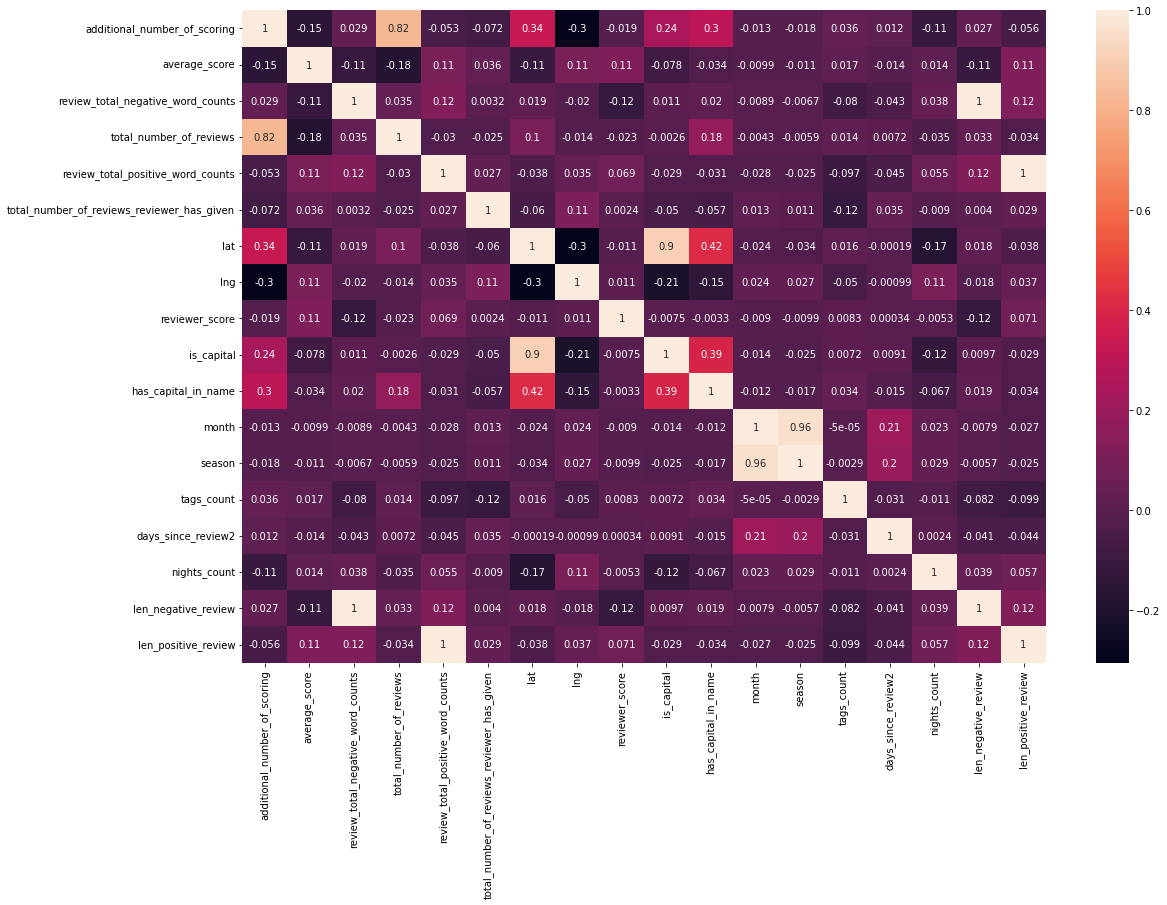

In [28]:
plt.rcParams['figure.figsize'] = (18,12)
sns.heatmap(df_eda.drop(['sample'], axis=1).corr(), annot=True)

# **Удаление неинформативных и мультиколлинеарных признаков**


**Выделим пары коллинеарных признаков с сильной корреляцией > 0.7:**

**len_negative_review - review_total_negative_word_count**

**len_positive_review - review_total_positive_word_count**

**is_capital          -  lat**

**total_number_of_reviews   -   additional_number_of_scoring**

**season                    - month**




In [29]:
# ЭТИ ПРИЗНАКИ ДОЛЖНЫ БЫТЬ УДАЛЕНЫ НО ИХ УДАЛЕНИЕ ДАЛО ХУДШИЙ РЕЗУЛЬТАТ 'season', 'additional_number_of_scoring', 'len_negative_review','len_positive_review'
# УДАЛИМ ТОЛЬКО lat и lng
#,'season','review_total_negative_word_counts','review_total_positive_word_counts',
df_eda.drop(['lat','lng'],axis=1,inplace=True)

# 2.5 КОДИРОВАНИЕ ПРИЗНАКОВ

**Признаки 'reviewer_nationality', 'country_name', 'country_adr' содержат более 15 значений поэтому используем binary encoding**

In [30]:
from sklearn import preprocessing
import category_encoders as ce # импорт для работы с кодировщиком
# закодируем признаки
binary_encoded_features = ['reviewer_nationality', 'country_name', 'country_adr']
bin_encoder = ce.BinaryEncoder(cols=binary_encoded_features) # указываем столбец для кодирования
df_bin_encoded = bin_encoder.fit_transform(df_eda[binary_encoded_features])
df_eda = pd.concat([df_eda, df_bin_encoded], axis=1)


**Признаки season и month содержат меньше 15 значений поэтому используем onehot encoding**


In [31]:
onehot_encoded_features = ['month', 'season']
encoder = ce.OneHotEncoder(cols=onehot_encoded_features) # указываем столбец для кодирования
df_onehot_encoded = encoder.fit_transform(df_eda[onehot_encoded_features])
df_eda = pd.concat([df_eda, df_onehot_encoded], axis=1)

In [32]:
data=df_eda

In [33]:
# для нормализации, стандартизации
from sklearn import preprocessing

In [34]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop(['review_date'],axis=1,inplace=True)

# 2.7. НОРМАЛИЗАЦИЯ

In [35]:
cols_normilized=['review_total_negative_word_counts','review_total_positive_word_counts','nights_count', 'len_negative_review','len_positive_review','additional_number_of_scoring','tags_count','days_since_review2','average_score','total_number_of_reviews','total_number_of_reviews_reviewer_has_given']
# инициализируем нормализатор RobustScaler
mm_scaler = preprocessing.RobustScaler()
# копируем исходный датасет
d_copy = data.copy()
df_mm = mm_scaler.fit_transform(d_copy[cols_normilized])
# Преобразуем промежуточный датасет в полноценный датафрейм
df_mm = pd.DataFrame(df_mm, columns=cols_normilized)
df_clean = data.drop(cols_normilized,axis=1)
data = df_clean.join(df_mm)


**Нормализация и стандртизация не оказыват влияния на результаты модели случйного леса**


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   sample                                      515738 non-null  int64  
 1   reviewer_score                              515738 non-null  float64
 2   is_capital                                  515738 non-null  int64  
 3   has_capital_in_name                         515738 non-null  int64  
 4   month                                       515738 non-null  int64  
 5   season                                      515738 non-null  int64  
 6   reviewer_nationality_0                      515738 non-null  int64  
 7   reviewer_nationality_1                      515738 non-null  int64  
 8   reviewer_nationality_2                      515738 non-null  int64  
 9   reviewer_nationality_3                      515738 non-null  int64  
 

In [37]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [38]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [39]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

In [40]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [41]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9134477613612368


<AxesSubplot:>

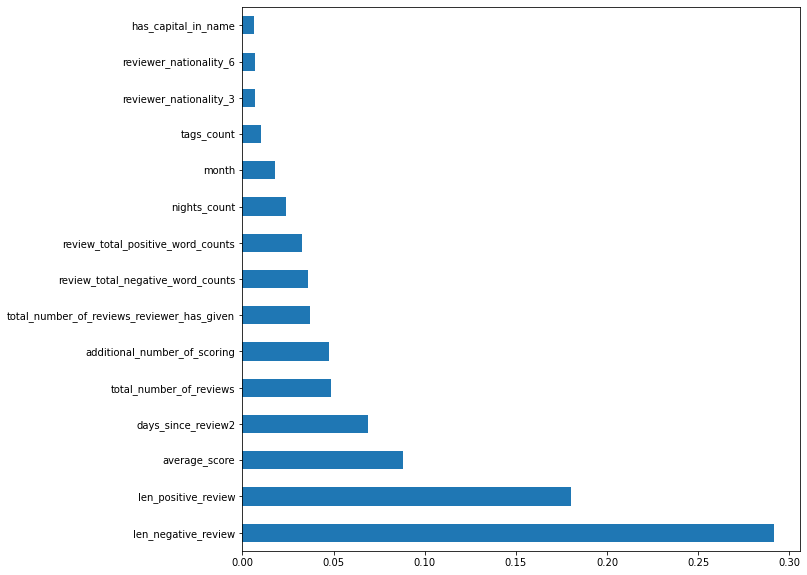

In [44]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [45]:
test_data.sample(10)

reviewer_score  is_capital  has_capital_in_name  month  season  \
111930             0.0           1                    0     10       4   
21899              0.0           1                    0      7       3   
116157             0.0           1                    1      7       3   
108686             0.0           0                    0      4       2   
106153             0.0           1                    0      1       1   
78656              0.0           1                    1      8       3   
60329              0.0           1                    1      1       1   
34659              0.0           1                    1      3       2   
66696              0.0           1                    1     11       4   
118324             0.0           0                    0     10       4   

        reviewer_nationality_0  reviewer_nationality_1  \
111930                       0                       0   
21899                        0                       0   
116157                       0                       0   
108686                       0                       0   
106153                       0                       0   
78656                        0                       0   
60329                        0                       0   
34659                        0                       0   
66696                        0                       0   
118324                       0                       0   

        reviewer_nationality_2  reviewer_nationality_3  \
111930                       0                       0   
21899                        0                       0   
116157                       0                       0   
108686                       0                       0   
106153                       0                       0   
78656                        0                       0   
60329                        1                       0   
34659                        0                       0   
66696                        0                       0   
118324                       0                       0   

        reviewer_nationality_4  ...  review_total_positive_word_counts  \
111930                       0  ...                          -0.529412   
21899                        0  ...                          -0.647059   
116157                       0  ...                          -0.058824   
108686                       0  ...                           0.705882   
106153                       1  ...                           0.705882   
78656                        0  ...                          -0.411765   
60329                        0  ...                          -0.647059   
34659                        0  ...                           0.294118   
66696                        1  ...                          -0.294118   
118324                       0  ...                          -0.176471   

        nights_count  len_negative_review  len_positive_review  \
111930           0.0            -0.048544            -0.537634   
21899            0.5            -0.194175            -0.516129   
116157           0.0             0.262136            -0.010753   
108686           2.0             0.320388             0.763441   
106153           0.5            -0.291262             0.741935   
78656            0.0             0.611650            -0.430108   
60329            0.5             8.203883            -0.516129   
34659           -0.5            -0.291262             0.247312   
66696            0.5             0.203883            -0.236559   
118324           0.0             0.475728            -0.172043   

        additional_number_of_scoring  tags_count  days_since_review2  \
111930                     -0.450102        -1.0            0.886364   
21899                      -0.515275        -1.0           -0.980114   
116157                      0.297352         0.0           -0.934659   
108686                      0.199593         0.0           -0.713068   
106153       

In [46]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [47]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [48]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [49]:
predict_submission

array([8.772, 7.122, 8.083, ..., 7.96 , 9.593, 7.626])

In [50]:
list(sample_submission)

['reviewer_score', 'id']

In [51]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.772  488440
1           7.122  274649
2           8.083  374688
3           9.546  404352
4           9.803  451596
5           8.439  302161
6           8.155  317079
7           7.951   13963
8           8.743  159785
9           7.858  195089